In [5]:
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms

image_folder = "generated_images"
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
labels = [" ".join(f.split('_')[1:-1]) for f in image_files]

In [20]:
import cv2
from PIL import Image, ImageOps
from torchvision import transforms
import numpy as np

image_paths = [os.path.join(image_folder, f) for f in image_files]
train_paths, test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

def parse_function(filename):
    image = cv2.imdecode(np.fromfile(filename, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if cv2.countNonZero(image) > (image.shape[0] * image.shape[1] // 2):
        image = cv2.bitwise_not(image)

    image = Image.fromarray(image, 'L')

    transform = transforms.Compose([
        transforms.Resize((100, 300)),
        transforms.ToTensor()
    ])

    return transform(image)


train_images = torch.stack([parse_function(f) for f in train_paths])
train_labels = [str(label) for label in y_train]
test_images = torch.stack([parse_function(f) for f in test_paths])
test_labels = [str(label) for label in y_test]

label_to_images = {}
for image, label in zip(train_images, train_labels):
    if label not in label_to_images:
        label_to_images[label] = []
    label_to_images[label].append(image)

generated_images\ъ8с вkWx_Roboto_Flex_Regular.png
generated_images\тСЁg Xуы_Flow_Circular_Regular.png
generated_images\Б8bКF8а_Wix_Madefor_Text_Regular.png
generated_images\UпЩГнЪ_PT_Serif_Caption_Regular.png
generated_images\ЁСk2мж_Rubik_Spray_Paint_Regular.png
generated_images\оOбЛzщ_EB_Garamond_Regular.png
generated_images\щ NЛ3GGUBuAaТ_Sofia_Sans_Extra_Condensed_Regular.png
generated_images\Zа чЩA6Д_Podkova_Regular.png
generated_images\nOsEО_Exo_2_Regular.png
generated_images\ъчнXюgй_Ysabeau_Office_Regular.png
generated_images\Yh9qЗПoЪD_Oranienbaum_Regular.png
generated_images\zq3 Еf8b_Montserrat_Regular.png
generated_images\pqЬДф7_Rubik_Distressed_Regular.png
generated_images\XфbуiПпГ_M_PLUS_1p_Regular.png
generated_images\бЭ нkSeM_Roboto_Slab_Regular.png
generated_images\5gхKнхAJ_Cuprum_Regular.png
generated_images\WТйUjиЦ_Charis_SIL_Regular.png
generated_images\Ьj уd_Oi_Regular.png
generated_images\ШЛ ёuJ_Yeseva_One_Regular.png
generated_images\Gп5 BtPiU_STIX_Two_Text_Regular.pn

In [21]:
import random

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, label_to_images):
        self.label_to_images = label_to_images
        self.triplet_indices = []

        for label, images in self.label_to_images.items():
            other_labels = [k for k in label_to_images.keys() if k != label]
            for anchor_idx, anchor_img in enumerate(images):
                for _ in range(1):
                    positive_idx = random.choice(range(len(images)))
                    negative_label = random.choice(other_labels)
                    negative_idx = random.choice(range(len(self.label_to_images[negative_label])))

                    self.triplet_indices.append((label, anchor_idx, positive_idx, negative_label, negative_idx))

    def __len__(self):
        return len(self.triplet_indices)

    def __getitem__(self, idx):
        label, anchor_idx, positive_idx, negative_label, negative_idx = self.triplet_indices[idx]
        anchor_img = self.label_to_images[label][anchor_idx]
        positive_img = self.label_to_images[label][positive_idx]
        negative_img = self.label_to_images[negative_label][negative_idx]

        return anchor_img, positive_img, negative_img

triplet_dataset = TripletDataset(label_to_images)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(),
            nn.Conv2d(32, 32, 3), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3), nn.ReLU(),
            nn.Conv2d(64, 64, 3), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3), nn.ReLU(),
            nn.Conv2d(128, 128, 3), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sum((anchor - positive)**2, dim=1)
        neg_dist = torch.sum((anchor - negative)**2, dim=1)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return torch.mean(loss)

model = BaseNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(1, 100, 300))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 98, 298]             320
              ReLU-2          [-1, 32, 98, 298]               0
            Conv2d-3          [-1, 32, 96, 296]           9,248
              ReLU-4          [-1, 32, 96, 296]               0
         MaxPool2d-5          [-1, 32, 48, 148]               0
            Conv2d-6          [-1, 64, 46, 146]          18,496
              ReLU-7          [-1, 64, 46, 146]               0
            Conv2d-8          [-1, 64, 44, 144]          36,928
              ReLU-9          [-1, 64, 44, 144]               0
        MaxPool2d-10           [-1, 64, 22, 72]               0
           Conv2d-11          [-1, 128, 20, 70]          73,856
             ReLU-12          [-1, 128, 20, 70]               0
           Conv2d-13          [-1, 128, 18, 68]         147,584
             ReLU-14          [-1, 128,

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

class ResNet18Font(nn.Module):
    def __init__(self):
        super(ResNet18Font, self).__init__()
        resnet = models.resnet18(pretrained=True)

        # Заменяем первый сверточный слой, чтобы принимать одноканальные изображения
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Удаляем последний полносвязный слой, чтобы получить эмбеддинги
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(20480, 512), nn.ReLU(),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sum((anchor - positive)**2, dim=1)
        neg_dist = torch.sum((anchor - negative)**2, dim=1)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return torch.mean(loss)

model = ResNet18Font()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(1, 300, 100))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 150, 50]           3,136
       BatchNorm2d-2          [-1, 64, 150, 50]             128
              ReLU-3          [-1, 64, 150, 50]               0
         MaxPool2d-4           [-1, 64, 75, 25]               0
            Conv2d-5           [-1, 64, 75, 25]          36,864
       BatchNorm2d-6           [-1, 64, 75, 25]             128
              ReLU-7           [-1, 64, 75, 25]               0
            Conv2d-8           [-1, 64, 75, 25]          36,864
       BatchNorm2d-9           [-1, 64, 75, 25]             128
             ReLU-10           [-1, 64, 75, 25]               0
       BasicBlock-11           [-1, 64, 75, 25]               0
           Conv2d-12           [-1, 64, 75, 25]          36,864
      BatchNorm2d-13           [-1, 64, 75, 25]             128
             ReLU-14           [-1, 64,

In [24]:
from collections import defaultdict
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

base_net = BaseNet().to(device)
triplet_loss = TripletLoss(margin=1)

# optimizer = optim.Adam(base_net.parameters(), lr=0.001)
optimizer = optim.RMSprop(base_net.parameters(), lr=0.001)

def euclidean_distance(a, b):
    return torch.norm(a - b, p=2)

def predict_font(embedding, average_embeddings):
    min_distance = float('inf')
    best_label = None

    embedding = torch.tensor(embedding) if type(embedding) is not torch.Tensor else embedding

    for label, avg_emb in average_embeddings.items():
        avg_emb = torch.tensor(avg_emb) if type(avg_emb) is not torch.Tensor else avg_emb
        distance = euclidean_distance(embedding, avg_emb)

        if distance.item() < min_distance:
            min_distance = distance.item()
            best_label = label

    return best_label

def predict_top_fonts(embedding, average_embeddings, top_n=3):
    distances = []

    embedding = torch.tensor(embedding) if type(embedding) is not torch.Tensor else embedding

    for label, avg_emb in average_embeddings.items():
        avg_emb = torch.tensor(avg_emb) if type(avg_emb) is not torch.Tensor else avg_emb
        distance = euclidean_distance(embedding, avg_emb)
        distances.append((label, distance.item()))

    distances.sort(key=lambda x: x[1])

    top_labels = [label for label, _ in distances[:top_n]]

    return top_labels

batch_size = 32
from tqdm import tqdm

def get_average_embeddings(images, labels, batch_size):
    test_embeddings = []
    for i in range(0, len(images), batch_size):
        test_batch = images[i:i+batch_size].to(device)

        batch_test_embeddings = base_net(test_batch).detach().cpu().numpy()
        test_embeddings.extend(batch_test_embeddings)

    label_to_embeddings = defaultdict(list)
    for emb, label in zip(test_embeddings, labels):
        label_to_embeddings[label].append(emb)

    average_embeddings = {label: np.mean(embs, axis=0) for label, embs in label_to_embeddings.items()}
    return average_embeddings, test_embeddings


average_embeddings = None
test_average_embeddings = {}
train_average_embeddings = {}

for epoch in range(12):
    triplet_dataset = TripletDataset(label_to_images)
    triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)
    pbar = tqdm(triplet_loader, desc=f"Epoch {epoch+1}")
    total_loss = 0.0
    batch_count = 0
    for batch in pbar:
        optimizer.zero_grad()

        anchors, positives, negatives = batch
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

        anchor_embedding = base_net(anchors)
        positive_embedding = base_net(positives)
        negative_embedding = base_net(negatives)

        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1
        average_loss = total_loss / batch_count

        pbar.set_postfix({"Batch Loss": loss.item(), "Average Loss": average_loss})


    correct_predictions_top_1 = 0
    correct_predictions_top_5 = 0
    epoch_test_average_embeddings, test_embeddings = get_average_embeddings(test_images, test_labels, batch_size)
    epoch_train_average_embeddings, train_test_embeddings = get_average_embeddings(train_images, train_labels, batch_size)

    test_average_embeddings[epoch] = epoch_test_average_embeddings
    train_average_embeddings[epoch] = epoch_train_average_embeddings

    for emb_tensor, true_label in zip(test_embeddings, test_labels):
        predicted_labels = predict_top_fonts(emb_tensor, epoch_train_average_embeddings, 5)
        if predicted_labels[0] == true_label:
            correct_predictions_top_1 += 1
        if true_label in predicted_labels:
            correct_predictions_top_5 += 1

    accuracy1 = (correct_predictions_top_1 / len(test_images)) * 100
    accuracy5 = (correct_predictions_top_5 / len(test_images)) * 100

    print(f"Accuracy top1/top5 after epoch {epoch+1}: {accuracy1} / {accuracy5}%")


Epoch 1: 100%|██████████| 1148/1148 [02:53<00:00,  6.60it/s, Batch Loss=0.258, Average Loss=4.81e+3]


Accuracy top1/top5 after epoch 1: 19.749455337690634 / 51.01307189542483%


Epoch 2: 100%|██████████| 1148/1148 [02:52<00:00,  6.67it/s, Batch Loss=0.305, Average Loss=0.334] 


Accuracy top1/top5 after epoch 2: 23.18082788671024 / 56.394335511982575%


Epoch 3: 100%|██████████| 1148/1148 [02:49<00:00,  6.78it/s, Batch Loss=0.303, Average Loss=0.261] 


Accuracy top1/top5 after epoch 3: 30.10893246187364 / 65.31590413943356%


Epoch 4: 100%|██████████| 1148/1148 [02:49<00:00,  6.79it/s, Batch Loss=0.347, Average Loss=0.199]  


Accuracy top1/top5 after epoch 4: 34.629629629629626 / 72.22222222222221%


Epoch 5: 100%|██████████| 1148/1148 [02:48<00:00,  6.81it/s, Batch Loss=0.0309, Average Loss=0.146] 


Accuracy top1/top5 after epoch 5: 37.069716775599126 / 74.56427015250546%


Epoch 6: 100%|██████████| 1148/1148 [02:48<00:00,  6.82it/s, Batch Loss=0.042, Average Loss=0.127]  


Accuracy top1/top5 after epoch 6: 44.88017429193899 / 82.99564270152506%


Epoch 7: 100%|██████████| 1148/1148 [02:50<00:00,  6.75it/s, Batch Loss=0.0236, Average Loss=0.115] 


Accuracy top1/top5 after epoch 7: 46.28540305010893 / 82.77777777777777%


Epoch 8: 100%|██████████| 1148/1148 [02:42<00:00,  7.05it/s, Batch Loss=0.0517, Average Loss=0.104] 


Accuracy top1/top5 after epoch 8: 49.29193899782135 / 85.45751633986927%


Epoch 9: 100%|██████████| 1148/1148 [02:47<00:00,  6.85it/s, Batch Loss=0.247, Average Loss=0.097]   


Accuracy top1/top5 after epoch 9: 50.33769063180827 / 87.00435729847494%


Epoch 10: 100%|██████████| 1148/1148 [02:53<00:00,  6.61it/s, Batch Loss=0.0347, Average Loss=0.0915] 


Accuracy top1/top5 after epoch 10: 50.27233115468409 / 87.82135076252723%


Epoch 11: 100%|██████████| 1148/1148 [02:46<00:00,  6.90it/s, Batch Loss=0.0597, Average Loss=0.089]  


Accuracy top1/top5 after epoch 11: 53.03921568627451 / 88.7363834422658%


Epoch 12: 100%|██████████| 1148/1148 [02:47<00:00,  6.84it/s, Batch Loss=0.122, Average Loss=0.0833]  


Accuracy top1/top5 after epoch 12: 49.79302832244009 / 87.26579520697167%


In [29]:
torch.save(base_net.state_dict(), 'model.pth')

In [31]:
import pickle
with open('test_average_embeddings.pkl', 'wb') as f:
    pickle.dump(test_average_embeddings[11], f)

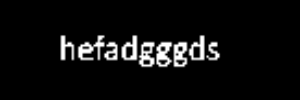

In [9]:
import cv2
from PIL import Image, ImageOps
from torchvision import transforms
import numpy as np

def parse_function(filename):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if cv2.countNonZero(image) > (image.shape[0] * image.shape[1] // 2):
        image = cv2.bitwise_not(image)

    image = Image.fromarray(image, 'L')

    transform = transforms.Compose([
        transforms.Resize((100, 300)),
        transforms.ToTensor()
    ])

    return transform(image)


image_tensor = parse_function("test.png")
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
pil_image = to_pil(image_tensor)
pil_image

In [18]:
import matplotlib.pyplot as plt
import numpy as np


for epoch, test_embeddings in test_average_embeddings.items():
    train_embeddings = train_average_embeddings[epoch]


    test_labels = list(test_embeddings.keys())
    test_values = np.array(list(test_embeddings.values()))
    test_x = test_values[:, 0]
    test_y = test_values[:, 1]


    train_labels = list(train_embeddings.keys())
    train_values = np.array(list(train_embeddings.values()))
    train_x = train_values[:, 0]
    train_y = train_values[:, 1]

    plt.figure(figsize=(15, 15))


    plt.scatter(test_x, test_y, c='blue')
    for i, label in enumerate(test_labels):
        plt.annotate(label, (test_x[i], test_y[i]), fontsize=8)


    plt.scatter(train_x, train_y, c='red')
    for i, label in enumerate(train_labels):
        plt.annotate(label, (train_x[i], train_y[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    plt.title(f"Epoch {epoch + 1}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(['Test', 'Train'])
    plt.show()


NameError: name 'test_average_embeddings' is not defined